In [18]:
import psycopg2
import time, cPickle, requests

import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

#Skip loading the data below by using this
#with open('./weather_data.cpickle') as infile:
#    invoices_supp = cPickle.load(infile)

In [79]:
conn = psycopg2.connect(user='postgres', database='Chinook', password='pgpass')
conn.autocommit = True

cur = conn.cursor()

def getQuery(query):
    """
    Perform a query on the database and return the results as a list of tuples
    """
    cur.execute(query)
    return cur.fetchall()

def getLatLon(location):
    """
    Uses the "Google-style geocoder" API at datasciencetoolkit.org to return the latitude and longitude for a location
    """
    url = 'http://www.datasciencetoolkit.org/maps/api/geocode/json?sensor=false&address='
    response = requests.get(url+location)
    location = response.json()['results'][0]['geometry']['location']
    return (location['lat'], location['lng'])

def getWeather(date, latlon):
    """
    Use the Historical API at worldweatheronline.com to return weather conditions for a latlon and date.
    """
    url = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=e13196bad2ce4aec9f2213413162603&q={latlon}&format=json&date={date}&tp=24'
    response = requests.get(url.format(latlon=str(latlon)[1:-1], date=date.strftime('%Y-%m-%d')))
    return response.json()

In [13]:
invoices = getQuery('select * from "Invoice"')

In [50]:
invoices_supp = []
for index, invoice in enumerate(invoices):
    if index%25==0:
        print index
    location = str(invoice[4])+', '+str(invoice[6])+' '+str(invoice[7])
    new_row = list(invoice)
    new_row.append(getLatLon(location))
    invoices_supp.append(new_row)
    time.sleep(1)

del invoices

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400


In [83]:
for index, row in enumerate(invoices_supp):
    if index%25==0:
        print index
    app = getWeather(row[2], row[-1])
    row.append(app)
    time.sleep(1)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400


In [25]:
column_names = ['invoice_id', 'customer_id', 'invoice_date', 'billing_address', 'billing_city', 'billing_state',
                'billing_country', 'billing_postal_code', 'total', 'latlon', 'weather_json'
               ]

def weather_states(weather_desc):
    if 'rain' in weather_desc.lower():
        return 'Rain'
    elif 'snow' in weather_desc.lower() or 'sleet' in weather_desc.lower():
        return 'Snow'
    elif 'sun' in weather_desc.lower():
        return 'Sun'
    else:
        return 'Clouds'

df = pd.DataFrame(invoices_supp, columns=column_names)
df.total = df.total.astype(float)
df['weather_desc'] = df.weather_json.apply(lambda x: x['data']['weather'][0]['hourly'][0]['weatherDesc'][0]['value'])
df['weather_state'] = df.weather_desc.apply(lambda x: weather_states(x))
df['precipitation'] = df.weather_json.apply(lambda x: float(x['data']['weather'][0]['hourly'][0]['precipMM']))
df['FeelsLikeF'] = df.weather_json.apply(lambda x: float(x['data']['weather'][0]['hourly'][0]['FeelsLikeF']))

In [35]:
pd.value_counts(df.weather_state)

Sun       178
Clouds    138
Rain       79
Snow       17
Name: weather_state, dtype: int64

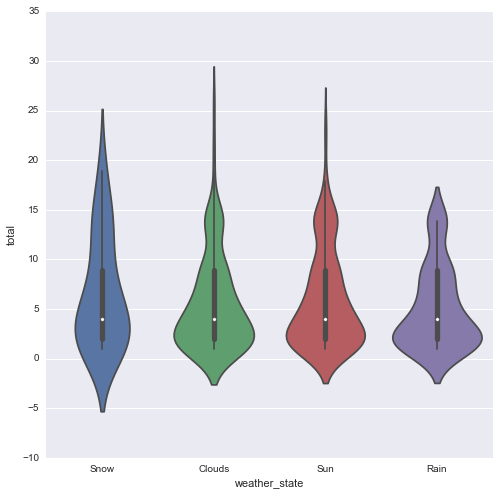

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
sb.violinplot(x='weather_state', y='total', data=df, ax=ax)

In [152]:
df[['total','precipitation', 'FeelsLikeF']].corr()

,total,precipitation,FeelsLikeF
total,1.000000,0.022877,0.027782
precipitation,0.022877,1.000000,-0.016635
FeelsLikeF,0.027782,-0.016635,1.000000


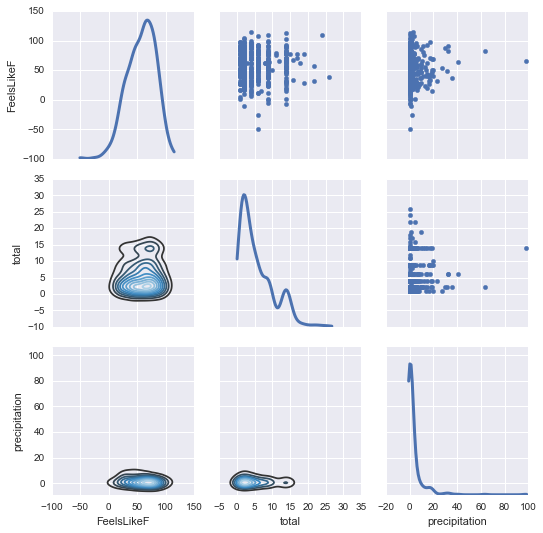

In [34]:
gb = df.groupby(['invoice_date','latlon']).agg({'total': sum, 'precipitation': np.mean, 'FeelsLikeF': np.mean})
g = sb.PairGrid(gb, diag_sharey=False)
g.map_lower(sb.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sb.kdeplot, lw=3)